Real NVP for 2 data

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
%matplotlib inline

In [22]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

In [4]:
def generate_moons_data(count):
  data, labels = make_moons(n_samples=count, noise=0.1)
  data = data.astype('float32')
  split = int(0.8 * count)
  train_data, test_data = data[:split], data[split:]
  train_labels, test_labels = labels[:split], labels[split:]
  return train_data, train_labels, test_data, test_labels

In [15]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.set_title('train')
  ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
  ax2.set_title('test')
  ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
  plt.show()

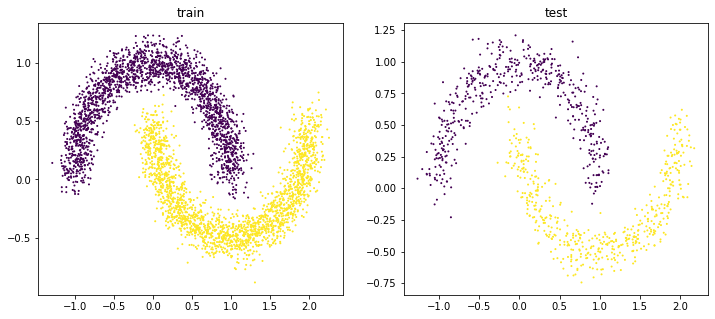

In [16]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

In [20]:
def show_2d_latents(latents, labels, title='Latent Space'):
  plt.figure()
  plt.title(title)
  plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
  plt.xlabel('z1')
  plt.ylabel('z2')

  plt.show()

def show_2d_densities(densities, title='Densities'):
  plt.figure()
  plt.title(title)
  dx, dy = 0.025, 0.025
  x_lim = (-1.5, 2.5)
  y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
  plt.xlabel('z1')
  plt.ylabel('z2')
  plt.show()

In [25]:
class FullyConnectedMLP(nn.Module):
  def __init__(self, input_shape, hiddens, output_shape):

    assert isinstance(hiddens, list)
    super().__init__()
    self.input_shape = (input_shape,)
    self.output_shape = (output_shape,)
    self.hiddens = hiddens

    # Stack some fully connected layers wirh relu activation.
    # Note that you do not have to add relu after the last fc layer
    self.net = []
    hidden_sizes = [input_shape] + hiddens + [output_shape]
    for layer_current, layer_next in zip(hidden_sizes,hidden_sizes[1:]):
      self.net.extend([nn.Linear(in_features=layer_current,out_features=layer_next), nn.ReLU()])
    self.net.pop() #remove final relu activational function
    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    return self.net(x)

In [29]:
def train_epoch(model, train_loader,optimizer,epoch,loss_key):
  model.train()
  stats = defaultdict(list)
  for x in train_loader:
    #x = Variable(x)# cuda
    optimizer.zero_grad()
    losses = model.loss(x)
    losses[loss_key].backward()
    optimizer.step()

    for k,v in losses.items():
      stats[k].append(v.item())
  return stats

In [27]:
def train_model(model, train_loader, test_loader, epochs, lr, loss_key):
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  train_losses = defaultdict(list)
  test_losses =  defaultdict(list)
  for epoch in range(epochs):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,epoch,loss_key)
    test_loss = eval_model(model,test_loader)

    for k in train_loss.keys():
      train_losses[k].extend(train_loss[k])
      test_losses[k].append(test_loss[k])
  return dict(train_losses), dict(test_losses)


In [41]:
def eval_model(model, data_loader):
  model.eval()
  stats = defaultdict(float)
  with torch.no_grad():
    for x in data_loader:
      #x = Variable(x)
      if False:
        x = x.cuda()
      losses = model.loss(x)
      for k,v in losses.items():
        stats[k]+=v.item()*x.shape[0]
    
    for k in stats.keys():
      stats[k] /= len(data_loader.dataset)
  return stats

In [52]:
def plot_training_curves(train_losses, test_losses):
  n_train = len(train_losses[list(train_losses.keys())[0]])
  n_test = len(test_losses[list(train_losses.keys())[0]])
  x_train = np.linspace(0, n_test - 1, n_train)
  x_test = np.arange(n_test)

  plt.figure()
  for key, value in train_losses.items():
    plt.plot(x_train, value, label=key + '_train')

  for key, value in test_losses.items():
    plt.plot(x_test, value, label=key + '_test')

  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [66]:
class AffineTransform(nn.Module):
  def __init__(self, partition_type, n_hiddens=[256, 256]):
    super().__init__()
    self.mask = self.build_mask(partition_type=partition_type) # return one mask for 2 points (x,y)
    self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.mlp = FullyConnectedMLP(input_shape=2, hiddens=n_hiddens, output_shape=2)

  def build_mask(self, partition_type):
    assert partition_type in {"left", "right"}
    if (partition_type == "left"):
      return torch.from_numpy(np.array([1,0]).astype(np.float32))
    else:
      return torch.from_numpy(np.array([0,1]).astype(np.float32))

  def forward(self, x, invert=False):
    # place your code here (you have to mask x)
    x_masked = x*self.mask 

    log_s, t = self.mlp(x_masked).split(1, dim=1)
    # see original paper to understand these formulas
    log_s = self.scale * torch.tanh(log_s) + self.scale_shift
    t = t * (1.0 - self.mask)
    log_s = log_s * (1.0 - self.mask)

    if (invert == False): # x = g(z)
      x = x_masked + ( (x*(1.0 - self.mask))*torch.exp(log_s.exp()) + t)
    else: # invert == True : z = f(x)
      x = x_masked + (x*(1.0 - self.mask) - t)* torch.exp(- log_s.exp() )
    #place your code here
    # you have to create forward and inverse transforms (use invert flag)
    return x, log_s

In [72]:
class RealNVP(nn.Module):
  def __init__(self):
    super().__init__()
    self.prior = torch.distributions.MultivariateNormal(torch.ones(2), torch.eye(2))
    self.transforms = nn.ModuleList([
            AffineTransform("right"),AffineTransform("left")
            # place your code here (stack AffineTransform) with alternately changing partition_mode
        ])
        
  def forward(self, x, invert=False):
    z = x
    log_det = 0.0
    # place your code here (do not forget abour invert flag)
    z,log_s = AffineTransform("right")(z, invert = False)
    for idx,transform in enumerate((self.transforms)):
      z,log_s = transform(z,invert=False)
      s = log_s.exp()
      log_det -= s.sum(dim=1)
    return z, log_det

  def log_prob(self, x):
    z,log_det = self.forward(x, invert = False)
    return self.prior.log_prob(z) + log_det
    # place your code here (use forward method)

  def loss(self, x):
    return {'nll_loss': -self.log_prob(x).mean()}

  def sample(self, n):
    # place your code here (sample from prior and put it to forward)
    return

In [103]:
real_nvp = RealNVP()

In [104]:
train_losses, test_losses = train_model(
    real_nvp, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='nll_loss'
)

KeyboardInterrupt: ignored

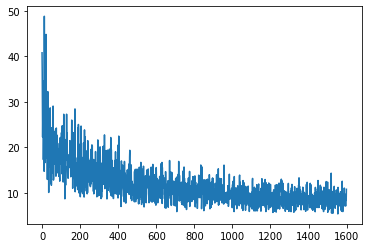

In [80]:
plt.plot(train_losses['nll_loss'])

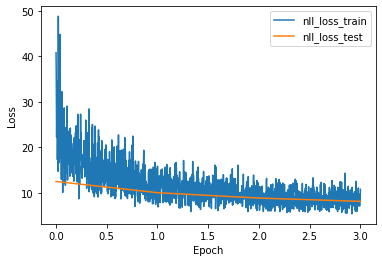

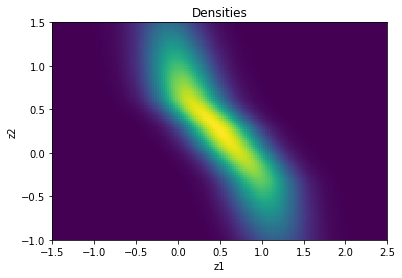

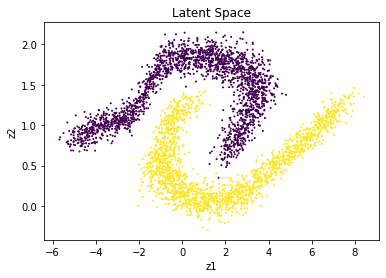

In [81]:
dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
densities = np.exp(real_nvp.log_prob(mesh_xs).cpu().detach().numpy())

# latents
z = real_nvp(torch.FloatTensor(train_data))[0]
latents = z.cpu().detach().numpy()

plot_training_curves(train_losses, test_losses)
show_2d_densities(densities)
show_2d_latents(latents, train_labels)

In [194]:
BATCH_SIZE = 100
EPOCHS = 500
LR = 1e-4
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = data.DataLoader(train_data, **loader_args)
test_loader = data.DataLoader(test_data, **loader_args)

In [89]:
class AffineTransform(nn.Module):
  def __init__(self, partition_type, n_hiddens=[256, 256]):
    super().__init__()
    self.mask = self.build_mask(partition_type=partition_type) # return one mask for 2 points (x,y)
    self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
    self.mlp = FullyConnectedMLP(input_shape=2, hiddens=n_hiddens, output_shape=2)

  def build_mask(self, partition_type):
    assert partition_type in {"left", "right"}
    if (partition_type == "left"):
      return torch.from_numpy(np.array([1,0]).astype(np.float32))
    else:
      return torch.from_numpy(np.array([0,1]).astype(np.float32))

  def forward(self, x, invert=False):
    # place your code here (you have to mask x)
    x_masked = x*self.mask 

    log_s, t = self.mlp(x_masked).split(1, dim=1)
    # see original paper to understand these formulas
    log_s = self.scale * torch.tanh(log_s) + self.scale_shift
    t = t * (1.0 - self.mask)
    log_s = log_s * (1.0 - self.mask)

    if (invert == False): # x = g(z)
      x = x_masked + ( (x*(1.0 - self.mask))*torch.exp(log_s.exp()) + t)
    else: # invert == True : z = f(x)
      x = x_masked + (x*(1.0 - self.mask) - t)* torch.exp(- log_s.exp() )
    #place your code here
    # you have to create forward and inverse transforms (use invert flag)
    return x, log_s

In [137]:
class RealNVP(nn.Module):
  def __init__(self):
    super().__init__()
    self.prior = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    self.transforms = nn.ModuleList([
            AffineTransform("right"),AffineTransform("left"),AffineTransform("right"),AffineTransform("left"),\
            AffineTransform("right"),AffineTransform("left")
            # place your code here (stack AffineTransform) with alternately changing partition_mode
        ])
        
  def forward(self, x, invert = False):
    z = x
    log_det = 0.0
    # place your code here (do not forget abour invert flag)
    #z,log_s = AffineTransform("right")(z, invert = True)
    for idx,transform in enumerate(self.transforms):
      z,log_s = transform(z,invert=True)
      s = log_s.exp()
      log_det -= s.sum(dim=1)
    return z, log_det

  def log_prob(self, x):
    z,log_det = self.forward(x, invert = True)
    return self.prior.log_prob(z) + log_det
    # place your code here (use forward method)

  def loss(self, x):
    return {'nll_loss': -self.log_prob(x).mean()}

  def sample(self, n):
    # place your code here (sample from prior and put it to forward)
    return

In [195]:
real_nvp = RealNVP()

In [196]:
train_losses, test_losses = train_model(
    real_nvp, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='nll_loss'
)

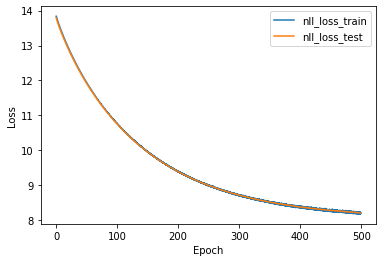

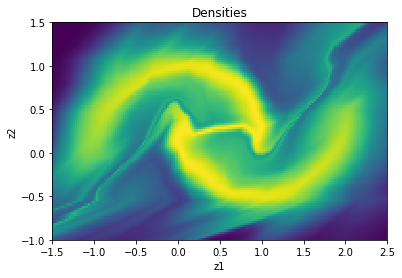

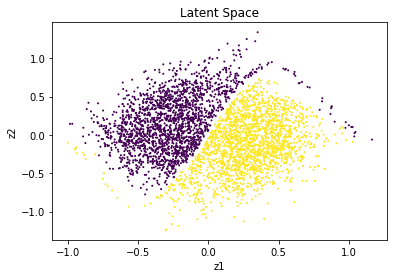

In [197]:
dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
densities = np.exp(real_nvp.log_prob(mesh_xs).cpu().detach().numpy())

# latents
z = real_nvp(torch.FloatTensor(train_data))[0]
latents = z.cpu().detach().numpy()

plot_training_curves(train_losses, test_losses)
show_2d_densities(densities)
show_2d_latents(latents, train_labels)